### STATS 202 
Waseh Ahmad
Summer 2019

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
#import statements
# import matplotlib.pyplot as plt
# from matplotlib.colors import Colormap
import random
import matplotlib
matplotlib.use('Agg') # set the backend before importing pyplot

import matplotlib.pyplot as plt # etc. etc.

from matplotlib.colors import Colormap
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import warnings
import sklearn
from scipy import stats
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,LeaveOneOut,cross_validate, GridSearchCV
from sklearn import linear_model, kernel_ridge
from statsmodels.graphics.gofplots import ProbPlot
from scipy.cluster import hierarchy
from sklearn.preprocessing import normalize, scale, PolynomialFeatures
from sklearn.cluster import AgglomerativeClustering,KMeans
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.feature_selection import RFE 
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
import patsy
import library
from mpl_toolkits.mplot3d import Axes3D


warnings.filterwarnings('ignore')

/home/waseh95ahmad/anaconda3/lib/python3.5/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


### Load Data and variables

In [3]:
#load all studies
files = ['Study_A.csv','Study_B.csv','Study_C.csv','Study_D.csv','Study_E.csv']
trials = []
for file in files:
    trials.append(pd.read_csv(file))
    
allTrialsDF = pd.concat(trials)

#ERROR value in 'Country' variable needs to be corrected
#60014 --> USA
#60025 --> Russia
allTrialsDF['Country'][(allTrialsDF.Country == "ERROR") & (allTrialsDF.SiteID==60014)] = "USA"
allTrialsDF['Country'][(allTrialsDF.Country == "ERROR") & (allTrialsDF.SiteID==60025)] = "RUSSIA"


#Create dummy variables for Study
allTrialsDF['TxGroup'] = pd.factorize(allTrialsDF.TxGroup)[0]
countryDummies = pd.get_dummies(allTrialsDF.Country,drop_first=True,prefix='Country')
studyDummies = pd.get_dummies(allTrialsDF.Study,drop_first=True,prefix='Study')
allTrialsDF = allTrialsDF.drop(['Country','Study'],axis=1)

allTrialsDF = pd.concat([allTrialsDF,countryDummies,studyDummies],axis=1)


In [4]:
#get ids of the users for whom we need to make predictions/classification
submissionIDs = pd.read_csv("sample_submission_PANSS.csv").PatientID

In [5]:
# add variables for lag, diff, sums of (p,n,g)

#sort the data by patient and visits
allSortedDF = allTrialsDF.sort_values(['PatientID', 'VisitDay'], ascending=[True, True]).reset_index().drop(['index'],axis=1)

# Add relative visit day variable
for name,group in allSortedDF.groupby('PatientID').__iter__():
    idx = 0
    for row_index,row in group.iterrows():
        allSortedDF.at[row_index,'RelativeVisitDay'] = idx
        idx+=1

#get sum of Ps,Ns,Gs
Ps=['P1', 'P2', 'P3', 'P4', 'P5','P6', 'P7']
Gs=['G1','G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11', 'G12', 'G13', 'G14', 'G15','G16']
Ns=['N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7']
allSortedDF['Ps'] = allSortedDF[Ps].sum(axis=1)
allSortedDF['Gs'] = allSortedDF[Gs].sum(axis=1)
allSortedDF['Ns'] = allSortedDF[Ns].sum(axis=1)

#diff of PANSS_Total
allSortedDF['PANSS_Total_diff_1'] = allSortedDF.groupby('PatientID')['PANSS_Total'].diff().fillna(0)

#get first lags for PANSS, Ps, Gs, Ns
for col in ['Ps','Ns','Gs','PANSS_Total']:
    newCol = col+"_lag_1"
    allSortedDF[newCol] = allSortedDF.groupby('PatientID')[col].shift(1)

In [6]:
allSortedDF.columns

Index(['AssessmentiD', 'G1', 'G10', 'G11', 'G12', 'G13', 'G14', 'G15', 'G16',
       'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'LeadStatus', 'N1',
       'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6',
       'P7', 'PANSS_Total', 'PatientID', 'RaterID', 'SiteID', 'TxGroup',
       'VisitDay', 'Country_Australia', 'Country_Austria', 'Country_Belgium',
       'Country_Brazil', 'Country_Bulgaria', 'Country_Canada', 'Country_China',
       'Country_Czech Republic', 'Country_France', 'Country_Germany',
       'Country_Greece', 'Country_Hungary', 'Country_India', 'Country_Japan',
       'Country_Korea', 'Country_Mexico', 'Country_Poland', 'Country_Portugal',
       'Country_RUSSIA', 'Country_Romania', 'Country_Russia',
       'Country_Slovakia', 'Country_Spain', 'Country_Sweden', 'Country_Taiwan',
       'Country_UK', 'Country_USA', 'Country_Ukraine', 'Study_B', 'Study_C',
       'Study_D', 'Study_E', 'RelativeVisitDay', 'Ps', 'Gs', 'Ns',
       'PANSS_Total_dif

In [7]:
formula = "PANSS_Total ~ TxGroup*VisitDay"
olsModel = smf.ols(formula,data=allSortedDF).fit()
olsModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            PANSS_Total   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     3791.
Date:                Thu, 08 Aug 2019   Prob (F-statistic):               0.00
Time:                        16:50:41   Log-Likelihood:                -95232.
No. Observations:               22909   AIC:                         1.905e+05
Df Residuals:                   22905   BIC:                         1.905e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           81.4695      0.200    407.855      0.000      81.078      81.861
TxGroup              0.3672      0.284      1.292      0.197      -0.190       0.924
VisitDay            -0.1161      0.002    -74.809      0.000      -0.119      -0.113
TxGroup:VisitDay    -0.0022      0.002     -0.995      0.320      -0.006       0.002
==============================================================================
Omnibus:                      420.844   Durbin-Watson:                   0.440
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              482.151
Skew:                           0.289   Prob(JB):                    2.01e-105
Kurtosis:                       3.412   Cond. No.                         470.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Patient Segmentation

In [8]:
firstVisits = allSortedDF.groupby('PatientID').first()[['PANSS_Total','Ps','Gs','Ns']]
# normalize the data and create a df out of it
firstVisitsScaled = normalize(firstVisits,axis=0)
firstVisitsScaledDF = pd.DataFrame(firstVisitsScaled, columns=firstVisits.columns)


labels = firstVisits.index.values
linked = hierarchy.linkage(firstVisitsScaledDF, 'complete',metric='euclidean')


In [9]:
plt.figure(figsize=(20, 7))  
dendrogram = hierarchy.dendrogram(linked,labels=labels)
plt.title("PatientSegmentation")
plt.axhline(y=0.025, color='r', linestyle='--')
plt.show() 

In [10]:
numClusters = 5
aggClustering = AgglomerativeClustering(n_clusters=numClusters, affinity='euclidean', linkage='complete')
aggClusteringFit = aggClustering.fit_predict(firstVisits)

# %matplotlib notebook
fig = plt.figure(figsize=(10, 10)) 
ax = fig.add_subplot(111, projection='3d')

img = ax.scatter(firstVisits.Ps,firstVisits.Ns, firstVisits.Gs, c=aggClustering.labels_, cmap='viridis_r', marker='o')
# fig.colorbar(img)

ax.set_xlabel('P sum')
ax.set_ylabel('N sum')
ax.set_zlabel('G sum')

plt.show()


In [11]:
kNNCenters = []
#get centers from previous clustering
for k in np.unique(aggClusteringFit):
    #for each parameter
    kthMeans = []
    for p in firstVisits.columns:
        #compute mean
        kthMeans.append(np.mean(firstVisits[p].loc[aggClustering.labels_ == k]))
    kNNCenters.append(np.asarray(kthMeans))
    
kMeansClusters = KMeans(n_clusters=numClusters,init=np.asarray(kNNCenters),random_state=1).fit(firstVisits)

#plot
fig = plt.figure(figsize=(10, 10)) 
ax = fig.add_subplot(111, projection='3d')

img = ax.scatter(firstVisits.Ps,firstVisits.Ns, firstVisits.Gs, c=kMeansClusters.labels_,cmap='viridis_r', marker='o')
# fig.colorbar(img)

ax.set_xlabel('P sum')
ax.set_ylabel('N sum')
ax.set_zlabel('G sum')

plt.show()

# Forecasting

In [12]:
#divide set into training and test data

#first, get all the possible attributes that we might want
studies = list(allSortedDF.columns[allSortedDF.columns.str.startswith("Study")== True])
# X = ['TxGroup','VisitDay','RelativeVisitDay','PANSS_Total_lag_1','Ps_lag_1','Gs_lag_1','Ns_lag_1']+studies
X = ['TxGroup','RelativeVisitDay','PANSS_Total_lag_1']+studies
y = ['PANSS_Total']

#remove first visits as we cannot use that to make predictions (there is no previous data on it)
removeFirstVisits = allSortedDF.loc[allSortedDF.RelativeVisitDay != 0]


xSet = removeFirstVisits[X]
ySet = removeFirstVisits[y]
xTrain, xTest, yTrain, yTest = train_test_split(xSet, ySet, test_size=0.25, random_state=0)
trainDF = pd.concat([xTrain,yTrain],axis=1)

In [13]:
#try linear regression
testMSEs = list()
trainMSEs = list()
for degree in range(1,7,1):
    trainFeatures = PolynomialFeatures(degree).fit_transform(xTrain)
    testFeatures = PolynomialFeatures(degree).fit_transform(xTest)
    linearModel = linear_model.LinearRegression().fit(trainFeatures,yTrain)
    #training MSE
    yPredTrainLM = linearModel.predict(trainFeatures)
    trainMSEs.append(library.GetMSE(yPredTrainLM,yTrain).values[0])
    #Test MSE
    yPredTestLM = linearModel.predict(testFeatures)
    testMSEs.append(library.GetMSE(yPredTestLM,yTest).values[0])


In [14]:
plt.plot(range(6),trainMSEs,c='red',label='TrainMSE')
plt.plot(range(6),testMSEs, c='blue',label='TestMSE')
plt.xlabel('Degree')
plt.ylabel('MSE')
plt.legend(loc='upper left')

In [ ]:
# #make the prediction by first making the df for the features being used
# inputDF = initialDF.loc[initialDF.PatientID.isin(idsToForecast)]
# # groupedDF = pd.DataFrame({'TxGroup':sortedDF.groupby('PatientID').TxGroup.agg(pd.Series.mode),'PANSS_diff_avg':sortedDF.groupby('PatientID').mean().PANSS_Total_diff})
# inputDF = inputDF.groupby('PatientID').last()
# inputDF.PANSS_Lag1 = inputDF.PANSS_Total 
# inputDF = inputDF.drop(['PANSS_Total'],axis=1)


# yPred = modelFit.predict(inputDF)

# submission = pd.DataFrame(yPred)
# # submission.to_csv("forecast_submit.csv")

# yPredLasso = lassoModelFit.predict(library.InjectFactors(inputDF,factorVars))
# submission = pd.DataFrame(yPredLasso)
# submission['PatientID'] = idsToForecast
# # submission.to_csv("forecast_submit_Lasso.csv",header=['PatientID','PANSS_Total'])

In [39]:
# Bagging approach

np.random.seed(5)
baseModel = DecisionTreeRegressor(random_state=1,max_leaf_nodes=32)
baggingModel = Pipeline([
  ('transformation', PolynomialFeatures(1)),
  ('feature_selection', RFE(baseModel,n_features_to_select=2)),
  ('regression', BaggingRegressor(base_estimator=baseModel,n_estimators=1000))
])
# baggingModelFit = baggingModel.fit(library.InjectFactors(xTrain,factorVars),yTrain)
#run CV on pipeline
# scores = cross_validate(baggingModel, PolynomialFeatures(4).fit_transform(library.InjectFactors(xTrain,factorVars)),yTrain, cv=5,scoring='neg_mean_squared_error',return_estimator=True)

#degree = 1 has better time with a slightly worse MSE (0.09)
param0 = {'transformation__degree':[1,2]}
# n_features to select = 2 , for simplicity. not much improvement from more
param1 = {'feature_selection__n_features_to_select':[1,2,4,8,16,32]}

#max leaf nodes = 16, n_estimators = 1000
param2 = {'regression__base_estimator__max_leaf_nodes':[2,4,8,16,32],
          'regression__n_estimators':[10,100,1000,3000]}

#uncomment the followign line to run the tuning
# tuneOutput = GridSearchCV(baggingModel, param2, scoring='neg_mean_squared_error', cv=4).fit(xTrain,yTrain)

<ErrorbarContainer object of 3 artists>

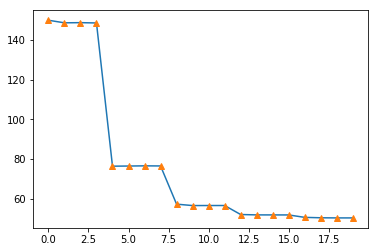

In [40]:
results = pd.DataFrame(tuneOutput.cv_results_)
plt.plot(range(len(results)),np.abs(results.mean_test_score))
plt.errorbar(range(len(results)),np.abs(results.mean_test_score),linestyle='None', marker='^')

# print("Features To select:"+str(results.iloc[12].param_feature_selection__n_features_to_select))
# print("Number of Polynomials:"+str(results.iloc[12].param_transformation__degree))

In [54]:
baggingModel.set_params(feature_selection__n_features_to_select=2, transformation__degree=1,regression__base_estimator__max_leaf_nodes=16,regression__n_estimators=1000)
baggingModelFit = baggingModel.fit(xTrain,yTrain)  
yPredTrain = baggingModelFit.predict(xTrain)
yPredTest = baggingModelFit.predict(xTest)
print("Train MSE:"+str(library.GetMSE(yPredTrain,np.asarray(yTrain.PANSS_Total))))
print("Test MSE:"+str(library.GetMSE(yPredTest,np.asarray(yTest.PANSS_Total))))


Train MSE:50.91456156657022
Test MSE:54.46099120011082


In [37]:
# #create a set of predictions
# baggingModelFit = baggingModel.fit(PolynomialFeatures(4).fit_transform(library.InjectFactors(xTrain,factorVars)),yTrain)
# predictions = baggingModelFit.predict(PolynomialFeatures(4).fit_transform(library.InjectFactors(inputDF,factorVars)))

# submission = pd.DataFrame(predictions)
# submission['PatientID'] = idsToForecast
# submission.to_csv("forecast_submit_Bagging.csv",header=['PatientID','PANSS_Total'])

In [15]:
# boosting approach

max_depth = 3
min_child_weight = 10
subsample = 0.5
colsample_bytree = 0.6
objective = 'reg:squarederror'
num_estimators = 3000
learning_rate = 0.01

boostModel = xgb.XGBRegressor(max_depth=max_depth,
                min_child_weight=min_child_weight,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
                objective=objective,
                n_estimators=num_estimators,
                learning_rate=learning_rate)

eval_set = [(xTrain, yTrain), (xTest, yTest)]
xgbModelFit = boostModel.fit(xTrain, yTrain, eval_set=eval_set, verbose=False)

In [16]:
yPredTrain = xgbModelFit.predict(xTrain)
yPredTest = xgbModelFit.predict(xTest)

print("Train MSE:"+str(library.GetMSE(yPredTrain,np.asarray(yTrain.PANSS_Total))))
print("Test MSE:"+str(library.GetMSE(yPredTest,np.asarray(yTest.PANSS_Total))))


# predictions = xgbModelFit.predict(inputDFWithCategories)
# submission = pd.DataFrame(predictions)
# submission['PatientID'] = idsToForecast
# submission.to_csv("forecast_submit_XGB.csv",header=['PANSS_Total','PatientID'])

Train MSE:46.9002237092
Test MSE:51.7819561621


In [27]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

def xgb_cv(max_depth,learning_rate):
    model = xgb.XGBRegressor(max_depth=int(max_depth),min_child_weight=5.75,learning_rate=learning_rate,n_estimators=2000,objective='reg:squarederror',seed=1)
    cval = cross_val_score(model,xTrain,yTrain,scoring='neg_mean_squared_error',cv=4)
    return cval.mean()
params={'max_depth':(2,8),'learning_rate':(0.0001,0.01)}
optimizer = BayesianOptimization(f=xgb_cv,pbounds=params,random_state=1234,verbose=1)
optimizer.maximize(n_iter=10)

|   iter    |  target   | learni... | max_depth |
-------------------------------------------------
|  2        | -49.11    |  0.004434 |  6.712    |
|  3        | -48.6     |  0.007822 |  3.636    |


In [17]:
# tune xgboost
#max_depth = int(3.6) learning  = 0.007822
#best values found 3,6 respectively
param_test1 = {
 'max_depth':[2,4,6,8],
 'min_child_weight':[2,4,6,8],
}
#best gamma value found = 0.4
param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
#0.85 and 0.85
param_test3 = {
 'subsample':[i/10.0 for i in [2,4,6,8,10]],
 'colsample_bytree':[i/10.0 for i in [2,4,6,8,10]]
}

param_test4 = {
    'learning_rate':np.logspace(-3,0,7)
}
params=param_test1
params.update(param_test2)
params.update(param_test3)

gsearch1 = GridSearchCV(estimator=xgb.XGBRegressor(learning_rate =0.01, n_estimators=2000,max_depth=3,min_child_weight=6,
                                                   gamma=0.4, subsample=0.85, colsample_bytree=0.85,
                                                   objective='reg:squarederror', scale_pos_weight=1, seed=1), 
                        param_grid = params, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
xgbGS1Fit = gsearch1.fit(xTrain, yTrain)
xgbGS1Fit.best_params_

KeyboardInterrupt: 

In [70]:
xgbModel = xgb.XGBRegressor(learning_rate =0.01, n_estimators=5000,max_depth=3,min_child_weight=6,
                                                   gamma=0.4, subsample=0.85, colsample_bytree=0.85,
                                                   objective='reg:squarederror', scale_pos_weight=1, seed=1)
xgbGS1Fit = xgbModel.fit(xTrain, yTrain)

yPredTrain = xgbGS1Fit.predict(xTrain)
yPredTest = xgbGS1Fit.predict(xTest)

print("Train MSE:"+str(library.GetMSE(yPredTrain,np.asarray(yTrain.PANSS_Total))))
print("Test MSE:"+str(library.GetMSE(yPredTest,np.asarray(yTest.PANSS_Total))))

Train MSE:42.5408039067463
Test MSE:51.701516729716985


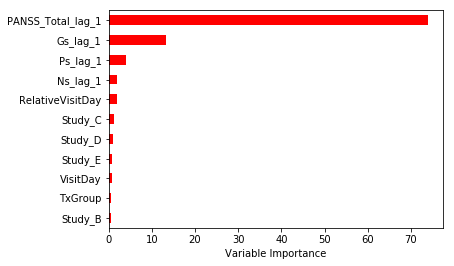

In [71]:
Importance = pd.DataFrame({'Importance':xgbGS1Fit.feature_importances_*100}, index=xTrain.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

In [45]:
#make the prediction by first making the df for the features being used
extraCols = ['Ps','Ns','Gs','PANSS_Total']
submissionXDF = allSortedDF.loc[allSortedDF.PatientID.isin(submissionIDs)][X+['PatientID']+extraCols]
submissionXDF = submissionXDF.groupby('PatientID').last()
for col in ['Ps','Ns','Gs','PANSS_Total']:
    submissionXDF[col] = submissionXDF[col+"_lag_1"]
submissionXDF = submissionXDF.drop(extraCols,axis=1)

# xSet[xSet['PatientID'] in submissionIDs]

In [51]:

predictions = xgbModelFit.predict(submissionXDF)
submission = pd.DataFrame(predictions)
submission['PatientID'] = submissionIDs
submission.to_csv("forecast_submit_XGB.csv",header=['PANSS_Total','PatientID'])

### References
1.https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
